# Assignment 10: Regression with discrete variables
## Learning Outcomes:
This assignment introduces the use of discrete variables in regression analysis. Task 1 will use discrete variables as explanatory variables, in Task 2 we will use discrete variables as response variables and introduce logistic regression. 

## Data set 
Throught the assignment you will use the full possum.csv data set.  
The data set includes measures from 104 possums that were caught in New Zealand in a field study. 
Variables: 
-	site: The site number where the possum was trapped.
-	pop: Population, either Vic (Victoria) or other (New South Wales or Queensland).
-	sex: Gender, either m (male) or f (female).
-	age: Age in years
-	headL: Head length, in mm.
-	skullW: Skull width, in mm.
-	totalL: Total length, in cm.
-	tailL: Tail length, in cm.

## Preliminaries
Set up the environment by importing pandas, numpy, and matplotlib, scipy.optimize. This is already done in the preliminaries. Ensure that you have fully mastered all previous assignments (especially 8, 9) before starting the assignment. Import the regression functions that you used for the last homeworks. 

In [1]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt 
%matplotlib inline
import scipy.optimize as so
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

def multRegPredict(b,D,xname):
    yp=np.ones(len(D.index))*b[0]        # Intercept 
    for i in range(len(xname)):          
        yp=yp+D[xname[i]]*b[i+1]         # Add each regression value 
    return yp 

def multRegLossRSS(b,D,y,xname):
    predY = multRegPredict(b,D,xname)
    res = y-predY
    rss = sum(res**2)
    grad=np.zeros(len(b))
    grad[0]=-2*np.sum(res)
    for i in range(len(xname)):
        grad[i+1]=-2*np.sum(D[xname[i]]*res)
    return (rss,grad)

def multRegFit(D,y,xname):
    N=len(xname)
    b0=np.zeros((N+1,1))
    RES = so.minimize(multRegLossRSS,b0,args=(D,y,xname),jac=True)
    if (not(RES.success)):
        print('unsuccessful fit')
        print(RES)
    b=RES.x # Results
    res = y-np.mean(y)
    TSS = sum(res**2)
    RSS,deriv = multRegLossRSS(b,D,y,xname)
    R2 = 1-RSS/TSS 
    return (R2,b)

def leaveOneOutCV(x,y,fitfcn=multRegFit,args=(),predictfcn=multRegPredict):
    N = len(x) #Number of observations 
    yp= np.zeros(N)
    ind = np.arange(N)
    for i in range(N):
        r,b,ax=fitfcn(x[ind!=i],y[ind!=i],args,fig=False)
        yp[i]=predictfcn(b,x[i])
    TSS  = sum((y-y.mean())**2)
    RSScv = sum((y-yp)**2)
    R2cv = 1-RSScv/TSS

    # Get the model fit 
    r,b,ax=fitfcn(x,y,args)
    yf=predictfcn(b,x)
    RSS   = sum((y-yf)**2)
    R2 = 1-RSS/TSS
    return R2cv,R2 
def bootstrapReg(D,y,args,fitfcn,numIter=1000):
    r2,b=fitfcn(D,y,args)
    numParams=len(b)
    N = len(D.index)
    ind  = np.arange(N)
    stats = np.zeros((numIter,numParams))
    for i in range(numIter):
        sample=np.random.choice(ind,N)
        r2,stats[i,:]=fitfcn(D.iloc[sample],y[sample],args)
    return stats

def confidenceInt(data,perc):
    Int=(np.percentile(data,(100-perc)/2),np.percentile(data,100-(100-perc)/2))
    return Int

## Task 1: Discrete predictor variables

### Question 1 (5 pt)
Load the data set possum.csv. 
Generate 3 new columns in the data frame: 
- bodyL: The length of the main body (totalL - tailL) 
- popI:  Population identifier, 0: if pop is 'other', 1: if pop is 'Vic'
- sexI:  Sex indentifier, 0: if sex is 'm', 1: if sex is 'f'
Use your function multRegression to run a regression analysis of bodyL (response variable) against sexI (explanatory variable). Make a plot (with labeled axes) that show sex on the x-axis and body length on the y axis. Add the prediction line from the regression. 

Text(0, 0.5, 'Body Length')

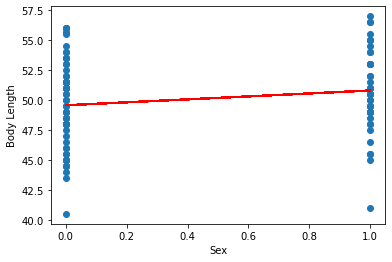

In [2]:
df = pd.read_csv('possum.csv')
df['bodyL'] = df.totalL-df.tailL
df['popl'] = df['pop']=='Vic'
df['sexl'] = df['sex']=='f'
df['popl'] = np.double(df['popl'])
df['sexl'] = np.double(df['sexl'])

R2, b = multRegFit(df,df.bodyL,['sexl'])
# 1. plot the scatter plot
plt.scatter(df['sexl'], df['bodyL'])
# 2. get the predicted values
yp = multRegPredict(b, df, ['sexl'])
plt.plot(df['sexl'], yp, color = 'r')
plt.xlabel('Sex')
plt.ylabel('Body Length')

### Question 2 (10pt)
Use boostrap to estimate a 95% confidence interval on the regression parameter of sex as a explanatory variable for body length. Report the interval. Can you reject the null-hypothesis that body length in possums does not differ between the sexes?  

In [3]:
confidenceInt(yp,95)

(49.56885245901639, 50.802325581395344)

> Yes, we reject the null hypothesis.

### Question 3 (10pt)
Make a scatter plot of age (x-axis) against body length (y-axis), with male and female possums shown in different colors. 
You can do this by plotting two scatter plots sequentially - each time selecting either male or female possums. The second one will simply add points in a different color to the first plot.  

Estimate a multiple regression model that explains bodyL as a function of age and sex. What is the R2-value? 

Get the predicted values from the regression, and plot the predicted values in the same graph seperately for male and female possums. 

R2 is 0.08543037213506444


Text(0.5, 0, 'Body Length')

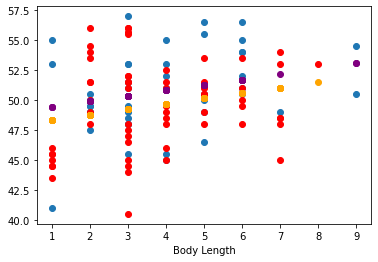

In [4]:
R2, b = multRegFit(df,df.bodyL,['sexl','age'])
print('R2 is',R2)
yp = multRegPredict(b, df, ['sexl','age'])

plt.scatter(df[df.sexl==1]['age'],df[df.sexl==1]['bodyL'])
plt.scatter(df[df.sexl==0]['age'],df[df.sexl==0]['bodyL'], color = 'red')
plt.scatter(df[df.sexl==1]['age'], yp[df.sexl==1], color = 'purple')
plt.scatter(df[df.sexl==0]['age'], yp[df.sexl==0], color = 'orange')
plt.xlabel('Age')
plt.xlabel('Body Length')

### Question 4 (7pt)
Run a bootstrap analysis on the bodyL ~ age + sexI regression model. Report the 95% confidence interval for the regression parameters of sex and age on body length. Is the effect of age onto body length significant in the context of the model? How about the relationship between sex and body length?  


In [225]:
boot = bootstrapReg(df,df.bodyL,['age','sexl'],multRegFit)
confidenceInt(boot,95)

unsuccessful fit
      fun: 1001.563291651619
 hess_inv: array([[ 0.03115369, -0.00523362, -0.01041859],
       [-0.00523362,  0.00127173,  0.00019512],
       [-0.01041859,  0.00019512,  0.01926229]])
      jac: array([-5.10920371e-06, -2.80060151e-05, -3.24851516e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 11
      nit: 8
     njev: 11
   status: 2
  success: False
        x: array([47.01864017,  0.60154537,  0.45408389])


(0.040275634131571154, 49.19603062654442)

> Because the interval doesn't include 0, it is significant

### Question 5 (10pt)
Estimate a multiple regression model that explains bodyL as a function of age and population (Vic vs. other). What is the R2-value? Make a scatter plot like for Question 3, but this time splitting the data for the two populations, rather than based on sex. Which of the two population (Vic or other) is larger? How do you interpret the value of the regression coefficient for popI? 

R2 is 0.17974517849498572


Text(0.5, 0, 'Body Length')

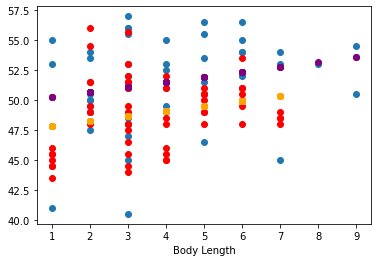

In [6]:
R2, b = multRegFit(df,df.bodyL,['popl','age'])
print('R2 is',R2)
yp = multRegPredict(b, df, ['popl','age'])

plt.scatter(df[df.popl==1]['age'],df[df.popl==1]['bodyL'])
plt.scatter(df[df.popl==0]['age'],df[df.popl==0]['bodyL'], color = 'red')
plt.scatter(df[df.popl==1]['age'], yp[df.popl==1], color = 'purple')
plt.scatter(df[df.popl==0]['age'], yp[df.popl==0], color = 'orange')
plt.xlabel('Age')
plt.xlabel('Body Length')

### Question 6 (8pt)
Run a bootstrap analysis on the bodyL ~ age + popI regression model. Report the 95% confidence interval for the regression parameters of popI and age on body length. Is the effect of age onto body length significant in the context of the model? How about the relationship between population and body length? 


In [7]:
boot0 = bootstrapReg(df,df.bodyL,['age','popl'],multRegFit)
confidenceInt(boot0,95)

(0.19356001713960547, 48.49725148141724)

> Because the interval doesn't include 0, it is significant

## Task 2: Discrete response variable
In this task we will investigate regression models in which the response variable is a discrete, dichotomous variable. 
### Question 1: Logistic Function (10pt)
Starting with your function for multRegPredict, write a function logisticRegPredict(b,D,xname). As inputs it should take the 
- b: np-array of regression coefficients (the first one being the intercept)
- D: Data frame
- xname: a list of column names (in D) that are being used as regressors. 

The function should first calculate a = b[0] + b[1] * D[xname[0]] + b[2] * D[xname[1]] 
and then return the logistic function of a. 

Then make a Data frame with a single column with the values from -4 to 4 (in small steps). Plot the logistic function for the parameter values: 
- b = [0,0]
- b = [0,1]
- b = [0,2]
- b = [0,-2]

What happens as the slope value changes? 

Then plot the logistic function for the parameter values: 
- b = [0,2]
- b = [1,2]
- b = [2,2]
- b = [-2,2]

What happens as the intercept value changes? For each value - where does the predicted line cross p=0.5? 



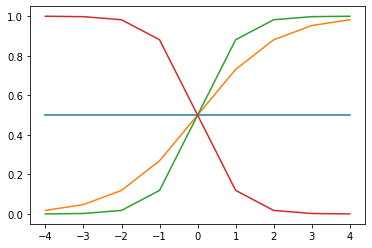

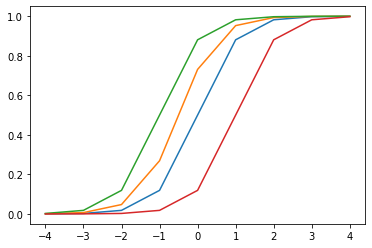

In [224]:
def logisticRegPredict(b,D,xname):
    # Start out with the intercept
    a = np.ones(len(D.index))*b[0]
    # Add the prediction of each regressor
    for i in range(len(xname)):
        a = a + D[xname[i]] * b[i+1] 
    yp = 1 / (1 + np.exp(-a)) # Logistic function of a
    return yp

data = [-4,-3,-2,-1,0,1,2,3,4]
df1 = pd.DataFrame(data=data)
p00 = logisticRegPredict([0,0],df1,[0])
p01 = logisticRegPredict([0,1],df1,[0])
p02 = logisticRegPredict([0,2],df1,[0])
p03 = logisticRegPredict([0,-2],df1,[0])

plt.plot(data, p00)
plt.plot(data, p01)
plt.plot(data, p02)
plt.plot(data, p03)
plt.show()

p10 = logisticRegPredict([0,2],df1,[0])
p11 = logisticRegPredict([1,2],df1,[0])
p12 = logisticRegPredict([2,2],df1,[0])
p13 = logisticRegPredict([-2,2],df1,[0])
plt.plot(data, p10)
plt.plot(data, p11)
plt.plot(data, p12)
plt.plot(data, p13)
plt.show()

What happens as the slope value changes?
> As slope value changes, the steepness of the model to cross 0.5 in the middle changes

What happens as the intercept value changes? For each value - where does the predicted line cross p=0.5?
> It changes the location of where it begins changing. For 0 it crosses 0.5 at 0, for 1 it crosses 0.5 at about -0.5, for 2 it crosses 0 at about -1.25, and at -2 it crosses 0 at about 1.25

### Question 2 (10pt)
Make a Scatterplot of tail length (as a x-variable) against popI (Population, 1:Victoria 0:other). 
Written answer: What relationship can you see? 


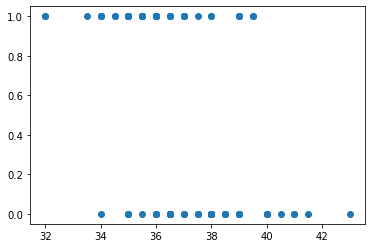

In [61]:
plt.scatter(df.tailL,df.popl)

> The higher the tailL, the more likely popL will be 0

### Question 3 (10pt)
Write a function logisticRegLoss(b,D,y,name) that calculates the Loss function for the logistic regression (negative log-likelihood, see lecture). The function should call logisticRegPredict to get the prediction, and then calculate the Loss and the derivative of the loss in respect to all regression paramaters. The function should be able to use multiple regressors (like multRegLossRSS from previous homeworks).    

Report the negative log likelihood (and derivates) for a logistic regression model that predicts popI as a function of tailL: 
- for the parameter values [0,0]
- for the parameter values [17.5,-0.5]
- for the parameter values [25.56,-0.7]

Which one is the best parameter setting of the three? 

In [62]:
def logisticRegLoss(b,D,y,xname):
    p = logisticRegPredict(b,D,xname)
    loss = -sum(y*np.log(np.abs(p))+(1-y)*np.log(np.abs(1-p)))
    N=len(xname) # Number of regressors
    grad=np.zeros(N+1) 
    res = y-p # Residuals
    grad[0]= -sum(res) # Gradient for b0
    for i in range(N):
        grad[i+1]= -sum(res*D[xname[i]])
    return (loss,grad)

print(logisticRegLoss([0,0],df,df.popl,['tailL']))
print(logisticRegLoss([17.5,-0.5],df,df.popl,['tailL']))
print(logisticRegLoss([25.56,-0.7],df,df.popl,['tailL']))

(72.08730677823438, array([  6. , 271.5]))
(63.01497836859202, array([ -14.65999642, -527.46450906]))
(56.72412770882332, array([ -0.37160079, -13.678462  ]))


> The best parameter of the three is [25.56,-0.7]

### Question 4 (10pt)
Write a function logisticRegFit(D,y,xname,figure=True) that fits the logistic model by minimizing the above Loss function. 
- D: A data frame with the explanatory variables 
- y: A dichotomous (0 or 1) response variable 
- xname: Names of x variables to be used 
- figure: Flag (True / False) indicating if the code should produce a figure. 
When there is only one x-variable, and figure==True, then function should produce a scatter plot of the data and the predicted values. 

The function should return the log-likelihood of the data under the best model and the best fitting (maximum liklihood) estimates of b. Remember that the function value you are minimizing is the *negative* log-likelihood, and the best fitting value is stored in RES.fun

Fit a logistic regression model that predicts popI as a function of tailL. Make sure the function generates a plot. Report log-likelihood and b-values. 

LL is 56.72051579544123 and b is [25.56620437 -0.69964061]


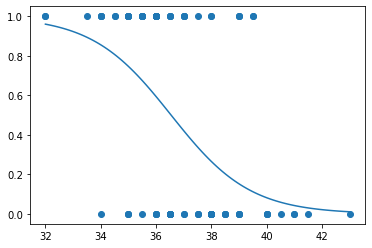

In [215]:
def logisticRegFit(D,y,xname,figure=True):
    RESULT = so.minimize(logisticRegLoss, np.zeros(len(xname)+1), args = (D,y,xname), jac = True)
    TSS = sum((y - np.mean(y))**2)
    RSS,grad = logisticRegLoss(RESULT.x,D,y,xname)
    R2 = 1-(RSS/TSS)
    if figure:
        plt.scatter(D[xname].sum(axis=1)/len(xname),y)
        entries = []
        for i in range(len(xname)):
            entries.append(np.linspace(min(D[xname[i]]), max(D[xname[i]]), len(D[xname[i]])))
        D_p = pd.DataFrame(entries).transpose()
        D_p = D_p.set_axis(xname, axis=1)
        plt.plot(D_p.sum(axis=1)/len(D_p.columns),logisticRegPredict(RESULT.x,D_p,xname))
    return RESULT.fun, RESULT.x

LL, b = logisticRegFit(df,df.popl,['tailL'])
print("LL is",LL,"and b is",b)

### Question 5 (10pt)
Now fit the model explaing popI from tailL and bodyL in a multiple logistic regression model. Report the log-likelihood and parameter values. Is the fit better than tailL alone? 

Also fit the model explaing popI from tailL and totalL in a multiple logistic regression model. Again, report the log-likelihood and parameter values. 

What do you observe in terms of log-likelihood and in terms of paramters? Why do these two models yield exactly the same log-liklihood? 

tailL+bodyL: LL is 43.20463551583587 and b is [16.57735312 -0.98846114  0.39180167]


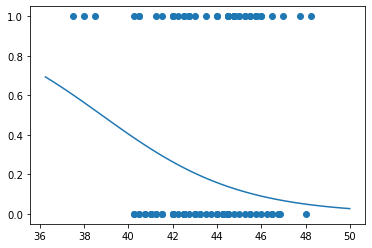

bodyL: LL is 64.07423950076063 and b is [-11.99811219   0.23409582]


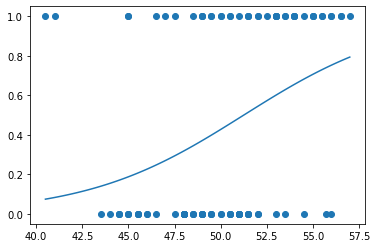

In [216]:
LL, b = logisticRegFit(df,df.popl,['tailL','bodyL'])
print("tailL+bodyL: LL is",LL,"and b is",b)
plt.show()
LL, b = logisticRegFit(df,df.popl,['bodyL'])
print("bodyL: LL is",LL,"and b is",b)

>Mine don't yield the same, and it looks inverted